In [1]:
import os
import numpy as np
import cv2
from skimage.transform import resize
import matplotlib.pyplot as plt
from skimage.transform import resize

# Load image, mask, label

In [2]:
##Load images, labels, masks
NPY_PATH = r"dataset\numpy"

labels = np.load(os.path.join(NPY_PATH,'labels.npy'))
t1w_images = (np.load(os.path.join(NPY_PATH,'T1W_images.npy')) / 255.0).astype(np.float32)
t2f_images = (np.load(os.path.join(NPY_PATH,'T2F_images.npy')) / 255.0).astype(np.float32)
t2w_images = (np.load(os.path.join(NPY_PATH,'T2W_images.npy')) / 255.0).astype(np.float32)
masks = (np.load(os.path.join(NPY_PATH,'Mask_images.npy')) / 255.0).astype(np.float32)

print(masks.shape)

(2356, 260, 320)


# Resize data

원본 데이터 width : 260 , height : 320 
결과 데이터 width : 256 , height : 256



In [3]:
# 모델의 입력 형태에 맞추기 위해 차원을 확장합니다.
# example. (,260,320) -> (,260,320,1)
t1w_images = np.expand_dims(t1w_images,axis=-1)
t2f_images = np.expand_dims(t2f_images,axis=-1)
t2w_images = np.expand_dims(t2w_images,axis=-1)
masks = np.expand_dims(masks,axis=-1)

In [4]:
from util import downsample

img_size_ori = (260,320)
img_size_target = (256,256)

t1w_images = np.array([ downsample(image,img_size_ori,img_size_target) for image in t1w_images ])
t2f_images = np.array([ downsample(image,img_size_ori,img_size_target) for image in t2f_images ])
t2w_images = np.array([ downsample(image,img_size_ori,img_size_target) for image in t2w_images ])
masks = (np.array([ downsample(mask,img_size_ori,img_size_target) for mask in masks ])>0)*1.0

<BarContainer object of 2 artists>

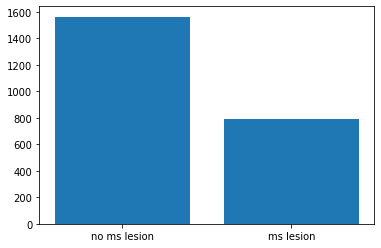

In [5]:
integer_to_class = {'0': 'no ms lesion', '1': 'ms lesion'}

classes, counts = np.unique(labels,return_counts=True)
plt.bar(classes,counts,tick_label=list(integer_to_class.values()))

In [6]:
from sklearn.model_selection import train_test_split
import gc

image_datasets = np.concatenate((t1w_images,t2f_images,t2w_images),axis=0)
mask_datasets = np.concatenate((masks,masks,masks),axis =0)
labels_datasets = np.concatenate((labels,labels,labels),axis =0)

print(image_datasets.shape)
print(mask_datasets.shape)
print(labels_datasets.shape)

(7068, 256, 256, 1)
(7068, 256, 256, 1)
(7068,)


### Train Image and its mask which is to be predicted

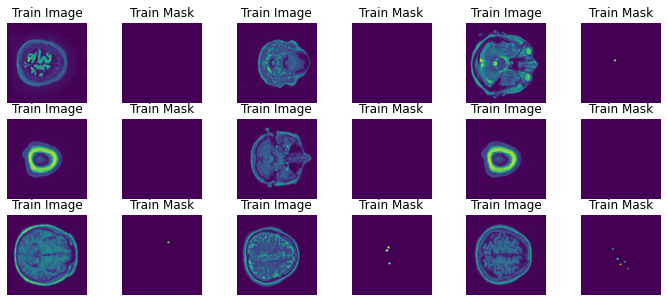

In [7]:
plt.figure(figsize=(12, 5))
i=1
for idx in np.random.randint( image_datasets.shape[0], size=9):
  plt.subplot(3,6,i);i+=1
  plt.imshow(image_datasets[idx])
  plt.title("Train Image")
  plt.axis('off')
  plt.subplot(3,6,i);i+=1
  plt.imshow(mask_datasets[idx]) 
  plt.title("Train Mask")
  plt.axis('off')

In [8]:
from sklearn.model_selection import train_test_split
import gc
X,X_v,Y,Y_v = train_test_split( image_datasets,mask_datasets,test_size=0.2,stratify=labels_datasets,random_state=444, shuffle=True)

del image_datasets
del mask_datasets
del labels_datasets

del t1w_images
del t2f_images
del t2w_images
del labels
del masks

gc.collect()

X.shape,X_v.shape

((5654, 256, 256, 1), (1414, 256, 256, 1))

### Augmentation

In [14]:
from model import baseModel, unet_v1, unet_v2, unet_v3, unet_v5
from keras import optimizers
from util import bce_dice_loss, historyToJson, historyToPng
from keras.metrics import MeanIoU
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, History
from keras.models import load_model
import json

model_options = [
	{
		'model_name': 'v5_1.3',
		'model' : unet_v5,
		'multiplier' : 1.3,
		'input_shape' : (256,256,1)
	},
    {
		'model_name': 'v5_1.5',
		'model' : unet_v5,
		'multiplier' : 1.5,
		'input_shape' : (256,256,1)
	},
    {
		'model_name': 'v5_1.8',
		'model' : unet_v5,
		'multiplier' : 1.8,
		'input_shape' : (256,256,1)
	},
    {
		'model_name': 'v5_2.0',
		'model' : unet_v5,
		'multiplier' : 2.0,
		'input_shape' : (256,256,1)
	}
]

for model_option in model_options:
 
    model_name = model_option['model_name']
    multiplier = model_option['multiplier']
    model = model_option['model']
    input_shape = model_option['input_shape']

    CHECKPOINT_NAME = f'model_{model_name}_best_checkpoint.h5'
    HISTORY_PATH = f'document/model_{model_name}_history.json'
    HISTORY_PNG_PATH = f'document/model_{model_name}_history.png'
    SUMMARY_PATH = f'document/model_{model_name}_summary.txt'
    
    unet = model(input_shape=input_shape, multiplier=multiplier)

    ## save model summary(architecture) 
    with open('SUMMARY_PATH','w') as txt_file:
        unet.summary(print_fn=lambda x : txt_file.write(x+'\n'))

    unet.compile(optimizer=optimizers.Adam(lr=1e-3), 
                loss=bce_dice_loss, metrics=['accuracy',MeanIoU(num_classes=2,name="mean_iou")])

    model_checkpoint  = ModelCheckpoint(CHECKPOINT_NAME, save_best_only=True, 
                                        monitor='val_loss', mode='min', verbose=1)
    early_stopping = EarlyStopping(monitor='val_loss', patience=7, mode='min' , baseline=None)
    reduceLR = ReduceLROnPlateau(patience=4, verbose=2, monitor='val_loss',min_lr=1e-4, mode='min')

    callback_list = [early_stopping, reduceLR, model_checkpoint]

    hist = unet.fit(
                        X,
                        Y,
                        batch_size=16,
                        epochs=100,
                        validation_data=(X_v,Y_v),
                        verbose=1,
                        callbacks= callback_list
            )

    history_dict = hist.history

    historyToJson(history_dict,HISTORY_PATH)
    historyToPng(history_dict,HISTORY_PNG_PATH)

   

NameError: name 'fh' is not defined